In [ ]:
!nvidia-smi

Mon Aug 15 05:35:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/proGAN

/content/drive/MyDrive/proGAN


In [ ]:
%load_ext tensorboard

In [ ]:
import os 
import numpy as np

import tensorflow as tf

from tensorflow.keras import Model
from google.colab import output

from functools import partial
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, UpSampling2D, \
AveragePooling2D, Activation, Reshape, Dense, Flatten, BatchNormalization

In [ ]:
START_IMG_SIZE = 16
START_EPOCH = 1
N_CRITIC = 5
EPOCH_TRAN_REV = 50
SAVE_N_EPOCH = 2
EPOCHS = 400
Z_DIM = 512
LAMBDA = 10
START_REV = 16
BATCH_SIZE = 12
TOTAL_ITER = 2500
LOG_DIR = "./logs/"

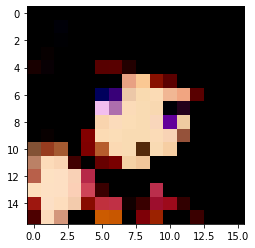

In [ ]:
# preprocess data

import pathlib

def normalize(image):
    '''
        normalizing the images to [-1, 1]
    '''
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

def preprocess_image(file_path, img_size):

    images = tf.io.read_file(file_path)

    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize(images, (img_size, img_size))
                          
    images = normalize(images)
    return images

data_path = pathlib.Path("./250rev_anime")
file_path = [str(path) for path in data_path.glob('*.jpg')]

train_data_path = tf.data.Dataset.from_tensor_slices(file_path)
preprocess = partial(preprocess_image, img_size=START_IMG_SIZE)
train_data = train_data_path.map(preprocess).shuffle(500).batch(BATCH_SIZE).repeat(len(train_data_path))

img = next(iter(train_data))

import matplotlib.pyplot as plt
plt.imshow(img[1])
plt.show()

In [ ]:

class MinibatchSTDDEV(tf.keras.layers.Layer):
    """
    Reference from official pggan implementation
    https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py
    
    Arguments:
      group_size: a integer number, minibatch must be divisible by (or smaller than) group_size.
    """
    def __init__(self, group_size=4):
        super(MinibatchSTDDEV, self).__init__()
        self.group_size = group_size

    def call(self, inputs):
        group_size = tf.minimum(self.group_size, tf.shape(inputs)[0])     # Minibatch must be divisible by (or smaller than) group_size.
        s = inputs.shape                                             # [NHWC]  Input shape.
        y = tf.reshape(inputs, [group_size, -1, s[1], s[2], s[3]])   # [GMHWC] Split minibatch into M groups of size G.
        y = tf.cast(y, tf.float32)                              # [GMHWC] Cast to FP32.
        y -= tf.reduce_mean(y, axis=0, keepdims=True)           # [GMHWC] Subtract mean over group.
        y = tf.reduce_mean(tf.square(y), axis=0)                # [MHWC]  Calc variance over group.
        y = tf.sqrt(y + 1e-8)                                   # [MHWC]  Calc stddev over group.
        y = tf.reduce_mean(y, axis=[1,2,3], keepdims=True)      # [M111]  Take average over fmaps and pixels.
        y = tf.cast(y, inputs.dtype)                                 # [M111]  Cast back to original data type.
        y = tf.tile(y, [group_size, s[1], s[2], 1])             # [NHW1]  Replicate over group and pixels.
        return tf.concat([inputs, y], axis=-1)                        # [NHWC]  Append as new fmap.
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], input_shape[3] + 1)


        

In [ ]:
# def block


def UpBlock(inp, f1, f2, kernal=3, stride=1, padding='same', name=''):
  x = UpSampling2D()(inp)
  x = Conv2D(f1, kernal, stride, padding=padding, name=name+'_conv1')(x)

  x = BatchNormalization()(x)
  x = Activation('leaky_relu')(x)

  x = Conv2D(f2, kernal, stride, padding=padding, name=name+'_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('leaky_relu')(x)

  return x


def DownBlock(inp, f1, f2, kernal=3, stride=1, padding='same', name=''):
  x = Conv2D(f1, kernal, stride, padding=padding, name=name+'_conv1')(inp)
  x = Activation('leaky_relu')(x)

  x = Conv2D(f2, kernal, stride, padding=padding, name=name+'_conv2')(x)
  x = Activation('leaky_relu')(x)

  x = AveragePooling2D()(x)
  return x

In [ ]:
# def model

filter_dic = [512, 512, 512, 512, 256, 128, 64, 32]
rev_dic = [4, 8, 16, 32, 64, 128, 256, 512]
kernel_initializer = 'he_normal'

def build_generator(noise_dim, level):

  inp = Input(noise_dim)
  alpha = Input((1), name='gen_alpha')
  start_lev = 2

  assert level >= start_lev, "level needs to be >= {}".format(start_lev)

  x = Dense(4*4*512, kernel_initializer=kernel_initializer, name='g_inp_dense')(inp)

  x = BatchNormalization()(x)
  x = Activation('leaky_relu')(x)
  x = Reshape((4, 4, 512))(x)

  x = Conv2D(filter_dic[0], 3, padding='same', kernel_initializer=kernel_initializer, name='g_inp_conv')(x)
  x = BatchNormalization()(x)
  x = Activation('leaky_relu')(x)

  #extending layer
  x = UpBlock(x, filter_dic[1], filter_dic[1], name="up_{}x{}".format(8,8))
  x = UpBlock(x, filter_dic[2], filter_dic[2], name="up_{}x{}".format(16,16))
  
  if level == start_lev:

    to_rgb = Conv2D(3, 3, 1, padding='same',kernel_initializer=kernel_initializer, name='to_rgb_{}x{}'.format(rev_dic[level], rev_dic[level]))
    curr_x = to_rgb(x)
    curr_x = Activation('tanh', name="tanh")(curr_x)

    return Model([inp, alpha], curr_x)

  for lev in range(start_lev, level):

    if lev == level-1:

      pre_x = UpSampling2D()(x)
      pre_to_rgb = Conv2D(3, 3, 1, padding='same', kernel_initializer=kernel_initializer, name='pre_rgb_{}x{}'.format(rev_dic[lev], rev_dic[lev]))
      pre_x = pre_to_rgb(pre_x)

    lev += 1
    x = UpBlock(x, filter_dic[lev], filter_dic[lev], name="up_{}x{}".format(rev_dic[lev],rev_dic[lev]))
  
  to_rgb = Conv2D(3, 3, 1, padding='same',kernel_initializer=kernel_initializer, name='to_rgb_{}x{}'.format(rev_dic[level], rev_dic[level]))
  curr_x = to_rgb(x)
  
  final_out = curr_x * alpha + pre_x * (1- alpha)

  model = Model([inp, alpha], final_out)

  return model



In [ ]:

def build_discriminator(inp_dim, level):

  inp = Input(inp_dim)
  alpha = Input((1,), name="dic_alpha")

  from_rgb = Conv2D(filter_dic[level], 3, 1, padding='same',activation=tf.nn.leaky_relu, kernel_initializer=kernel_initializer, name='from_rgb_{}x{}'.format(rev_dic[level], rev_dic[level]))

  pre_from_rgb = Conv2D(filter_dic[level-1], 3, 1, padding='same',activation=tf.nn.leaky_relu,kernel_initializer=kernel_initializer, name='pre_from_rgb_{}x{}'.format(rev_dic[level-1], rev_dic[level-1]))

  pre_x = AveragePooling2D()(inp)
  pre_x = pre_from_rgb(pre_x)

  curr_x = from_rgb(inp)
  curr_x = DownBlock(curr_x, filter_dic[level-1], filter_dic[level-1], name="down_{}x{}".format(rev_dic[level-1],rev_dic[level-1]))

  if level > 2:
    x = curr_x * alpha + pre_x * (1 - alpha)
  else:
    x = curr_x


  for lev in range(level-2, -1, -1):
    x = DownBlock(x, filter_dic[lev], filter_dic[lev], name="down_{}x{}".format(rev_dic[lev],rev_dic[lev]))

  x = MinibatchSTDDEV()(x)
  x = Conv2D(512, 3, 1, padding='same',kernel_initializer=kernel_initializer, name='d_out_conv1')(x)

  x = Activation('leaky_relu')(x)
  x = Conv2D(512, 4, 1, padding='valid',kernel_initializer=kernel_initializer, name='d_out_conv2')(x)

  x = Activation('leaky_relu')(x)
  x = Flatten()(x)

  final_out = Dense(1,kernel_initializer=kernel_initializer, name='d_out_dense')(x)
  model = Model([inp, alpha], final_out)
  return model



In [ ]:
# def train step

def d_train_step(generator, discriminator, real_image, alpha, batch_size=BATCH_SIZE):

    noise = tf.random.normal([batch_size, Z_DIM])
    epsilon = tf.random.uniform([batch_size, 1, 1, 1], minval=0, maxval=1)

    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            fake_image = generator([noise, alpha], training=True)
            
            fake_image_mixed = epsilon * real_image + ((1 - epsilon) * fake_image)
            fake_mixed_pred = discriminator([fake_image_mixed, alpha], training=True)
            
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        
        fake_pred = discriminator([fake_image, alpha], training=True)
        real_pred = discriminator([real_image, alpha], training=True)
        
        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
    
    D_gradients = d_tape.gradient(D_loss, discriminator.trainable_variables)
                                            
    
    D_optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))

    return D_loss
                                                


def g_train_step(generator, discriminator, alpha, batch_size=BATCH_SIZE):
   
    noise = tf.random.normal([batch_size, Z_DIM])

    with tf.GradientTape() as g_tape:
        fake_image = generator([noise, alpha], training=True)
        fake_pred = discriminator([fake_image, alpha], training=True)
        G_loss = -tf.reduce_mean(fake_pred)
        
    G_gradients = g_tape.gradient(G_loss, generator.trainable_variables)
                                            
   
    G_optimizer.apply_gradients(zip(G_gradients, generator.trainable_variables))

    return G_loss

In [ ]:
# build model instance

rev_lev_dic = {"4":0, "8":1, "16":2, "32":3, "64":4, "128":5, "256":6, "512":7}

#generator = build_generator((Z_DIM,), rev_lev_dic[str(START_REV)])
#generator.summary()

#discriminator = build_discriminator((START_REV, START_REV, 3), rev_lev_dic[str(START_REV)])
#discriminator.summary()

G_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, beta_1=0.5, beta_2=0.99, epsilon=1e-08)
D_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, beta_1=0.5, beta_2=0.99, epsilon=1e-08)


In [ ]:
if not os.path.exists('models'):
  os.mkdir('models')

if not os.path.exists('images'):
  os.mkdir('images')

In [ ]:
# save model_img output

import matplotlib.pyplot as plt

num_examples = 9
seed = tf.random.normal([num_examples, Z_DIM])  

def generate_and_save_imgs(G_net, epoch, seed, alpha=1):
  imgs = G_net([seed, alpha], training=False).numpy()
  
  for i in range(num_examples):
    img = imgs[i]
    img = (img + 1.0) * 127.5
    img = tf.cast(img, tf.uint8) 

    ax = plt.subplot(3,3,i+1)
    ax.imshow(img)
    plt.axis('off')
  
  plt.savefig("./final_img/epoch_{}_fake_image.jpg".format(epoch))
  plt.show()


save_epoch: 200 spent_time: 47.365442144870755min
curr_rev: 128 curr_d_loss: -124.14851379394531 curr_g_loss -15.047404289245605 curr_alpha: 1


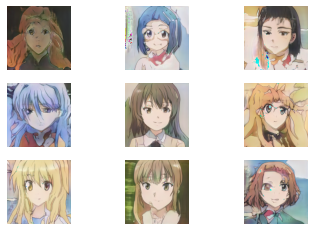

In [ ]:
# training

import pickle
import time 

alpha = 0
file_count = 0
n_critic_step = 0
img_size = START_IMG_SIZE
level = rev_lev_dic[str(START_REV)]

summary_Writer = tf.summary.create_file_writer(LOG_DIR)

if os.path.exists('./training_record.pkl'): # reload model record

  with open('./training_record.pkl', 'rb') as f:
    epoch, curr_rev, alpha = pickle.load(f)
    
  curr_rev = curr_rev
  pre_rev = curr_rev
  START_EPOCH = epoch + 1
  epoch = epoch
  alpha = alpha
  level = rev_lev_dic[str(curr_rev)]

  generator = build_generator((Z_DIM,), level)
  discriminator = build_discriminator((curr_rev, curr_rev, 3), level)

  generator.load_weights('./models/epoch{}_{}x{}_g_model.h5'.format(epoch, pre_rev, pre_rev), by_name=True)
  discriminator.load_weights('./models/epoch{}_{}x{}_d_model.h5'.format(epoch, pre_rev, pre_rev), by_name=True)

  preprocess = partial(preprocess_image, img_size=curr_rev)
  train_data = train_data_path.map(preprocess).shuffle(500).batch(BATCH_SIZE).repeat(len(train_data))

  print('curr_epoch {} alpha {} curr_rev {}'.format(START_EPOCH, alpha, curr_rev))



for epoch in range(START_EPOCH, EPOCHS):

  start_time = time.time()

  for iter, img in enumerate(train_data):
    if iter >= TOTAL_ITER:
      break

    if img.shape[0] != BATCH_SIZE:
      continue
    n_critic_step += 1

    d_loss = d_train_step(generator, discriminator, img, alpha)

    if n_critic_step % N_CRITIC == 0: 

      g_loss = g_train_step(generator, discriminator, alpha)
      n_critic_step = 0
    
    alpha = min(1, alpha + (1 / ((EPOCH_TRAN_REV / 2) * TOTAL_ITER)))
  

  with summary_Writer.as_default(): # write to tfboard

      tf.summary.scalar('g_loss', g_loss, step=epoch)
      tf.summary.scalar('d_loss', d_loss, step=epoch)

  if epoch % SAVE_N_EPOCH == 0:
    end_time = time.time()
    output.clear()

    print("save_epoch: {} spent_time: {}min".format(epoch, (end_time-start_time)/60))
    print("curr_rev: {} curr_d_loss: {} curr_g_loss {} curr_alpha: {}".format(img_size, d_loss, g_loss, alpha))

    generator.save_weights('./models/epoch{}_{}x{}_g_model.h5'.format(epoch, img_size, img_size))
    discriminator.save_weights('./models/epoch{}_{}x{}_d_model.h5'.format(epoch, img_size, img_size))

    file_count += 1
    if file_count > 5: # max file_num = 5

      os.remove('./models/epoch{}_{}x{}_g_model.h5'.format(epoch-10, img_size, img_size))
      os.remove('./models/epoch{}_{}x{}_d_model.h5'.format(epoch-10, img_size, img_size))

    seed = tf.random.normal([num_examples, Z_DIM]) 
    generate_and_save_imgs(generator, epoch, seed)

    data = (epoch, img_size, alpha)
    with open('./training_record.pkl', 'wb') as f:
      pickle.dump(data, f)
    
    if epoch == 200:
      break

  
  if epoch % EPOCH_TRAN_REV == 0: # transfer resolution

    alpha = 0
    file_count = 0
    level += 1
    pre_img_size = img_size
    img_size *= 2

    generator = build_generator((Z_DIM,), level)
    discriminator = build_discriminator((img_size, img_size, 3), level)

    generator.load_weights('./models/epoch{}_{}x{}_g_model.h5'.format(epoch, pre_img_size, pre_img_size), by_name=True)
    discriminator.load_weights('./models/epoch{}_{}x{}_d_model.h5'.format(epoch, pre_img_size, pre_img_size), by_name=True)

    preprocess = partial(preprocess_image, img_size=img_size)
    train_data = train_data_path.map(preprocess).shuffle(500).batch(BATCH_SIZE).repeat(len(train_data))
 


    

    


In [ ]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>